# Development Projection of Drone image on DEM
S. Filhol, Sept 2021


1. open image and load exif 
2. extract GPS location, camera absolute orientation and convert in UTM32
3. compute camera orientation from yaw pitch roll of camera and drone
4. open DEM for site.

In [1]:
import rasterio, glob
import exiftool
import PIL
from pyproj import Transformer
import geopandas as gpd
import pandas as pd
import ypr2okp

# 0. Create shapefile with Image Position

In [3]:
#path = "/home/simonfi/Dropbox (UiO)/Deer/Data/Fencing/07.03.2021 Fencing RGB 40m/"
path = "data/Fencing/20210307_Fencing_RGB_40m/"
out_gpkg = "20210307_fencing_RGB_40m.gpkg"
out_csv = "20210307_fencing_RGB_40m.csv"
file_imgs = glob.glob(path + '*.JPG')
file_imgs.sort()

extract_meta = False

df = pd.DataFrame()
if extract_meta:
    for file in file_imgs:
        # 1. open image
        with exiftool.ExifTool() as et:
            metadata = et.get_metadata(file)

        roll = float(metadata['XMP:GimbalRollDegree'])# + float(metadata['XMP:FlightRollDegree'])
        pitch = float(metadata['XMP:GimbalPitchDegree'])# + float(metadata['XMP:FlightPitchDegree'])
        yaw = float(metadata['XMP:GimbalYawDegree'])# + float(metadata['XMP:FlightYawDegree'])
        omega, phi, kappa = ypr2okp.ypr2opk(yaw, pitch, roll)

        loc_dict = {
            'img_name': file,
            'timestamp': pd.to_datetime(metadata['EXIF:DateTimeOriginal'], format='%Y:%m:%d %H:%M:%S'),
            'northing': float(metadata['EXIF:GPSLatitude']),
            'easting' : float(metadata['EXIF:GPSLongitude']),
            'elevation': float(metadata['EXIF:GPSAltitude']),
            'sensor_width': int(metadata['EXIF:ExifImageWidth']),
            'sensor_height': int(metadata['EXIF:ExifImageHeight']),
            'focal_length': float(metadata['EXIF:FocalLength'])*5472/13.2,
            'gimbal_roll': float(metadata['XMP:GimbalRollDegree']),
            'gimbal_pitch': float(metadata['XMP:GimbalPitchDegree']),
            'gimbal_yaw': float(metadata['XMP:GimbalYawDegree']),
            'flight_yaw': float(metadata['XMP:FlightYawDegree']),
            'flight_roll': float(metadata['XMP:FlightRollDegree']),
            'flight_pitch': float(metadata['XMP:FlightPitchDegree']),
            'omega' : omega,
            'phi':phi,
            'kappa':kappa
            }
        df = df.append(loc_dict, ignore_index=True)

    transformer = Transformer.from_crs("epsg:4326", "epsg:25833", always_xy=True)
    df['X'], df['Y'] = transformer.transform(df.easting, df.northing)
    df.to_csv(path + out_csv)
else:
    df = pd.read_csv(path + out_csv, index_col=0)

# TBT: how to declare geometry.
#gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df[['easting', 'northing']]), crs="EPSG:4326")
#gpf.to_crs("EPSG:32633")  #convert to UTM 33
#gpf.to_shapefile(path + out_gpkg, driver='GPKG')

In [4]:
df.head()

,easting,elevation,flight_pitch,flight_roll,flight_yaw,focal_length,gimbal_pitch,gimbal_roll,gimbal_yaw,img_name,kappa,northing,omega,phi,sensor_height,sensor_width,timestamp,X,Y
0,7.540315,110.0,-3.3,3.4,-179.2,4253.236364,-89.9,0.0,-173.6,data/Fencing/07.03.2021 Fencing RGB 40m/DJI_05...,-179.988783,61.047737,89.899373,-6.399990,3648.0,5472.0,2021-03-07 08:04:57,97748.916402,6.791065e+06
1,7.540315,112.0,-3.2,2.7,-179.0,4253.236364,-89.9,0.0,-173.0,data/Fencing/07.03.2021 Fencing RGB 40m/DJI_05...,-179.987722,61.047617,89.899249,-6.999989,3648.0,5472.0,2021-03-07 08:05:01,97747.402186,6.791052e+06
2,7.540311,114.0,-4.5,2.7,-178.9,4253.236364,-90.0,0.0,-172.9,data/Fencing/07.03.2021 Fencing RGB 40m/DJI_05...,-180.000000,61.047496,90.000000,-7.100000,3648.0,5472.0,2021-03-07 08:05:05,97745.655337,6.791039e+06
3,7.540307,116.0,-4.7,0.7,-179.6,4253.236364,-90.0,0.0,-172.9,data/Fencing/07.03.2021 Fencing RGB 40m/DJI_05...,-180.000000,61.047376,90.000000,-7.100000,3648.0,5472.0,2021-03-07 08:05:09,97743.921167,6.791025e+06
4,7.540304,118.0,-3.7,0.4,-179.7,4253.236364,-90.0,0.0,-172.8,data/Fencing/07.03.2021 Fencing RGB 40m/DJI_05...,-180.000000,61.047255,90.000000,-7.200000,3648.0,5472.0,2021-03-07 08:05:13,97742.194141,6.791012e+06


In [5]:
import numpy as np
def rot_matrix_from_angles(omega, phi, kappa):
        '''
        Rotation matrix from angles following Micmac convention
        '''
        RX = np.array([[1,0,0],
                 [0, np.cos(omega), -np.sin(omega)],
                 [0, np.sin(omega), np.cos(omega)]])    
        RY = np.array([[np.cos(phi), 0, np.sin(phi)],
                 [0,1,0],    
                 [-np.sin(phi), 0, np.cos(phi)]])
        RZ = np.array([[np.cos(kappa),-np.sin(kappa),0],
                 [np.sin(kappa), np.cos(kappa),0],
                 [0,0,1]])
        M = RX.dot(RY.dot(RZ))#.dot(np.array([[1,0,0],[0,-1,0],[0,0,-1]]))
        return M

In [6]:
from projimdem import projection as pr


In [51]:
#convert lat-lon to EPSG:25833
#path_to_dems = '/home/simonfi/Dropbox (UiO)/Deer/Data/Fencing/'
path_to_dems = 'data/Fencing/'
dem_file = path_to_dems + 'fencing_dtm_cropped_10cm.tif'

with open('gdal_clip_dem.sh', 'w') as f:
    for i, row in df.iterrows():
    
        output_clip_file = path_to_dems + 'dem_clip_' + row.img_name.split('/')[-1].split('.')[0] + '.tif'
        cmd_clip = 'gdal_translate -projwin ' + str(row.X-70) + ' ' + str(row.Y+70)  + ' ' + str(row.X+70) + ' ' + str(row.Y-70) + ' -of GTiff ' + dem_file +' '+ output_clip_file
        f.writelines(cmd_clip+'\n') 
    

In [7]:
path_to_dems = 'data/Fencing/'
dem_file = path_to_dems + 'fencing_dtm_cropped_10cm.tif'
for i, row in df.iterrows():
    #if i==10:
    #    break
        
    dem_local = path_to_dems + 'dem_clip_' + row.img_name.split('/')[-1].split('.')[0] + '.tif'
    viewshed_file = None #path_to_dems + 'viewshed_' + row.img_name.split('/')[-1].split('.')[0] + '.tif'
    image_file = row.img_name
    output_file = path_to_dems + 'projimg_' + row.img_name.split('/')[-1].split('.')[0] + '.tif'
    
    print(row.omega, row.phi, row.kappa)
    #rot_matrix = rot_matrix_from_angles((90-row.omega)*np.pi/180,row.phi*np.pi/180,row.kappa*np.pi/180)
    rot_matrix = rot_matrix_from_angles((90+row.gimbal_pitch)*np.pi/180, row.gimbal_roll*np.pi/180,row.gimbal_yaw*np.pi/180)
    
    cam_param = [[row.X, row.Y, row.elevation], 
                 rot_matrix, 
                 row.focal_length, 
                 [0,0],
                 [0,0,0,0,0,0,0,0,0,0,0,0]
                ]
    
    laerdal_proj = pr.Projection(dem_file=dem_local,
                                 viewshed_file=None,
                                 image_file=image_file,
                                 cam_param=cam_param,
                                 output_file=output_file)
    laerdal_proj.project_img_to_DEM(return_raster=True, epsg=25833)
    laerdal_proj = None
    

89.89937288496198 -6.399990211500454 -179.988783208638
ZDEMatCamera 65.037254
ZCamera 110.0


/home/arcticsnow/miniconda3/envs/livox/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/arcticsnow/miniconda3/envs/livox/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/arcticsnow/miniconda3/envs/livox/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

Ortho computed in 26.3021 seconds
Driver GTiff supports Create() method.
Driver GTiff supports CreateCopy() method.
Ortho computed
89.89924901899643 -6.999989285028556 -179.98772155031543
ZDEMatCamera 68.23325
ZCamera 112.0


/home/arcticsnow/miniconda3/envs/livox/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/arcticsnow/miniconda3/envs/livox/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/arcticsnow/miniconda3/envs/livox/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

Ortho computed in 26.4871 seconds
Driver GTiff supports Create() method.
Driver GTiff supports CreateCopy() method.
Ortho computed
90.0 -7.099999999999998 -180.0
ZDEMatCamera 68.210464
ZCamera 114.0


/home/arcticsnow/miniconda3/envs/livox/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/arcticsnow/miniconda3/envs/livox/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/arcticsnow/miniconda3/envs/livox/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

Ortho computed in 28.8358 seconds
Driver GTiff supports Create() method.
Driver GTiff supports CreateCopy() method.
Ortho computed
90.0 -7.099999999999998 -180.0
ZDEMatCamera 71.62031
ZCamera 116.0


/home/arcticsnow/miniconda3/envs/livox/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/arcticsnow/miniconda3/envs/livox/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/arcticsnow/miniconda3/envs/livox/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

Ortho computed in 29.3393 seconds
Driver GTiff supports Create() method.
Driver GTiff supports CreateCopy() method.
Ortho computed
90.0 -7.199999999999991 -180.0
ZDEMatCamera 73.54543
ZCamera 118.0


/home/arcticsnow/miniconda3/envs/livox/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/arcticsnow/miniconda3/envs/livox/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/arcticsnow/miniconda3/envs/livox/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

Ortho computed in 27.0112 seconds
Driver GTiff supports Create() method.
Driver GTiff supports CreateCopy() method.
Ortho computed
90.0 -7.199999999999991 -180.0
ZDEMatCamera 78.37954
ZCamera 120.0


/home/arcticsnow/miniconda3/envs/livox/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/arcticsnow/miniconda3/envs/livox/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/arcticsnow/miniconda3/envs/livox/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

Ortho computed in 26.1207 seconds
Driver GTiff supports Create() method.
Driver GTiff supports CreateCopy() method.
Ortho computed
89.89920520455243 -7.199988975684944 -179.98736706878182
ZDEMatCamera 81.52826
ZCamera 122.0


/home/arcticsnow/miniconda3/envs/livox/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/arcticsnow/miniconda3/envs/livox/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/arcticsnow/miniconda3/envs/livox/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

Ortho computed in 27.9705 seconds
Driver GTiff supports Create() method.
Driver GTiff supports CreateCopy() method.
Ortho computed
89.89920520455243 -7.199988975684944 -179.98736706878182
ZDEMatCamera 82.84509
ZCamera 124.0


/home/arcticsnow/miniconda3/envs/livox/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/arcticsnow/miniconda3/envs/livox/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/arcticsnow/miniconda3/envs/livox/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

Ortho computed in 26.7747 seconds
Driver GTiff supports Create() method.
Driver GTiff supports CreateCopy() method.
Ortho computed
90.0 -7.199999999999991 -180.0
ZDEMatCamera 83.86827
ZCamera 125.0


/home/arcticsnow/miniconda3/envs/livox/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/arcticsnow/miniconda3/envs/livox/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/arcticsnow/miniconda3/envs/livox/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

Ortho computed in 26.3364 seconds
Driver GTiff supports Create() method.
Driver GTiff supports CreateCopy() method.
Ortho computed
89.89920520455243 -7.199988975684944 -179.98736706878182
ZDEMatCamera 86.14545
ZCamera 127.0


/home/arcticsnow/miniconda3/envs/livox/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/arcticsnow/miniconda3/envs/livox/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/arcticsnow/miniconda3/envs/livox/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

Ortho computed in 28.0363 seconds
Driver GTiff supports Create() method.
Driver GTiff supports CreateCopy() method.
Ortho computed


In [38]:
laerdal_proj.image.shape

(3648, 5472, 3)

In [8]:
focal_length = 10.3

df_img = pd.DataFrame()
df_img['R'] = laerdal_proj.image[:,:,0].flatten()
df_img['G'] = laerdal_proj.image[:,:,1].flatten()
df_img['B'] = laerdal_proj.image[:,:,2].flatten()

xs = np.arange(0, laerdal_proj.image.shape[1]) - laerdal_proj.image.shape[1]/2
ys = - (np.arange(0, laerdal_proj.image.shape[0]) - laerdal_proj.image.shape[0]/2)

Xs, Ys = np.meshgrid(xs,ys)

df_img['X_img_pix'] = Xs.flatten()
df_img['Y_img_pix'] = Ys.flatten()
df_img['X_img_m'] = (Xs.flatten()* (13.2/5472))/1000
df_img['Y_img_m'] = (Ys.flatten()* (13.2/5472))/1000

#improve method by interpolating Z from porjection of DEM onto image sensor
df_img['Z_img_m'] = 110 

In [60]:
110/(focal_length/1000)

13.197587719298244

In [9]:
cam_param = [[row.X, row.Y, row.elevation], 
                 rot_matrix, 
                 row.focal_length, 
                 [0,0],
                 [0,0,0,0,0,0,0,0,0,0,0,0]
                ]

imgXYZ = df_img[['X_img_m','Y_img_m','Z_img_m']]
df_img[['X_proj', 'Y_proj', 'Z_proj']] = pd.DataFrame(np.add(cam_param[1].T.dot(imgXYZ.T).T*110 , cam_param[0]))

In [12]:
cam_param[1].T.dot(imgXYZ.T).T*110

array([[-1.68652903e+00, -2.15487706e+01,  1.20999807e+04],
       [-1.68679273e+00, -2.15487410e+01,  1.20999807e+04],
       [-1.68705643e+00, -2.15487114e+01,  1.20999807e+04],
       ...,
       [-3.02081678e+00, -2.04253042e+01,  1.20999824e+04],
       [-3.02108047e+00, -2.04252747e+01,  1.20999824e+04],
       [-3.02134417e+00, -2.04252451e+01,  1.20999824e+04]])

In [11]:
df_img.X_proj

0           97747.229873
1           97747.229609
2           97747.229345
3           97747.229082
4           97747.228818
                ...     
19961851    97745.896112
19961852    97745.895849
19961853    97745.895585
19961854    97745.895321
19961855    97745.895057
Name: X_proj, Length: 19961856, dtype: float64

In [ ]:


bins_x = np.linspace(np.round(df_img.X_proj.min(),1), np.round(df_img.X_proj.max(),1), nx+1)



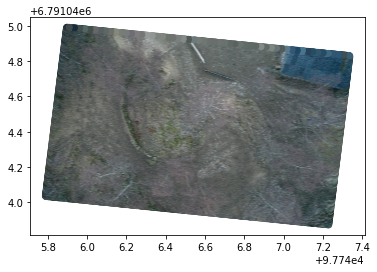

In [10]:
import matplotlib.pyplot as plt
plt.scatter(df_img.X_proj.iloc[0:df_img.shape[0]:100], df_img.Y_proj.iloc[0:df_img.shape[0]:100], c= df_img[['R','G','B']].iloc[0:df_img.shape[0]:100].values/255)

In [49]:
np.reshape(laerdal_proj.pt_proj.Y_distort.shape(laerdal_proj.image.shape)

ValueError: cannot reshape array of size 2252 into shape (3648,5472,3)

In [ ]:
path = "/home/simonfi/Dropbox (UiO)/Deer/Data/Fencing/07.03.2021 Fencing RGB 40m/"
file_imgs = glob.glob(path + '*.JPG')
file_imgs.sort()

# open DEM
rasterio.open()

# Include in for loop 
for file in file_imgs:
    
    # 1. open image
    
    # 2. Extract EXIF
    
    # Compute viewshed for camera location
    


    laerdal_proj = pi.ProjIm2dem(dem_file=dem_file,
                              viewshed_file=viewshed_file,
                              image_file=image_file,
                              cam_param=finse.new_cam.proj_param,
                               output_file=output_file
                              )
    laerdal_proj.ProjectImage2DEM(return_raster=True, epsg=32633)


In [13]:
import exifread
image = "/home/simonfi/Dropbox (UiO)/Deer/Data/Fencing/07.03.2021 Fencing RGB 40m/DJI_0597.JPG"
# Open image with ExifMode to collect EXIF data
exif_tags = open(image, 'rb')
tags = exifread.process_file(exif_tags, stop_tag='XMP')

In [55]:
tags['Image DateTime'].values

'2021:03:07 08:07:07'

In [13]:
from exiftool import ExifTool

image = "/home/simonfi/Dropbox (UiO)/Deer/Data/Fencing/07.03.2021 Fencing RGB 40m/DJI_0597.JPG"
et = ExifTool()
metadata = et.get_metadata(filename=image)
for d in metadata:
    print("{:20.20} {:20.20}".format(d["SourceFile"],
                                     d["EXIF:DateTimeOriginal"]))

ValueError: ExifTool instance not running.

In [44]:
float(tags['GPS GPSLatitude'].values[1])/60

0.03333333333333333

In [17]:

from PIL import Image, ExifTags


# Read image into imageio for data type
#pic = imageio.imread(image)

# Read image into PIL to extract basic metadata
type = Image.open(image)


In [18]:
# Calculations
megapixels = (type.size[0]*type.size[1]/1000000) # Megapixels

print("--Summary--\n")
print("Filename: ",type.filename)

print("Mode: ",type.mode)
print("Palette: ",type.palette)
print("Width: ", type.size[0])
print("Height: ", type.size[1])
print("Megapixels: ",megapixels)
print("")

--Summary--

Filename:  /home/simonfi/Dropbox (UiO)/Deer/Data/Fencing/07.03.2021 Fencing RGB 40m/DJI_0597.JPG
Mode:  RGB
Palette:  None
Width:  5472
Height:  3648
Megapixels:  19.961856



In [20]:
print(type)

<PIL.MpoImagePlugin.MpoImageFile image mode=RGB size=5472x3648 at 0x7F810D6405E0>


In [23]:
import PIL.Image
img = PIL.Image.open(image)
exif_data = img._getexif()

import PIL.ExifTags
exif = {
    PIL.ExifTags.TAGS[k]: v
    for k, v in img._getexif().items()
    if k in PIL.ExifTags.TAGS
}

In [24]:
exif

{'ImageWidth': 5472,
 'ImageLength': 3648,
 'BitsPerSample': (8, 8, 8),
 'ImageDescription': 'default',
 'Make': 'Hasselblad',
 'Model': 'L1D-20c',
 'Orientation': 1,
 'YCbCrPositioning': 1,
 'SamplesPerPixel': 3,
 'XResolution': 72.0,
 'YResolution': 72.0,
 'XPComment': b'0\x00.\x009\x00.\x001\x004\x002\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00',
 'XPKeywords': b's\x00i\x00n\x00g\x00l\x00e\x00',
 'GPSInfo': {0: b'\x02\x03\x00\x00',
  1: 'N',
  2: (61.0, 2.0, 49.4613),
  3: 'E',
  4: (7.0, 32.0, 26.4496),
  5: b'\x00',
  6: 122.0},
 'ResolutionUnit': 2,
 'ExifOffset': 332,
 '